In [11]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_EPOCHS = 10
IMG_SIZE = 32
N_CLASSES = 10

In [14]:
'''
  Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
  correct = 0
  total = 0
  
  with torch.no_grad():
    model.eval()
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return 100*(correct/total)

'''
  Function for plotting training and validation losses
'''
def plot_losses(train_losses, valid_losses):
  # change the style of the plots to seaborn
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize=(8, 4.5))

  ax.plot(train_losses, color="blue", label="Training_loss")
  ax.plot(valid_losses, color="red", label="Validation_loss")
  ax.set(title="Loss over epochs",
          xlabel="Epoch",
          ylabel="Loss")
  ax.legend()
  fig.show()

  # change the plot style to default
  plt.style.use('default')

'''
  function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # backward and optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)

  return model, optimizer, epoch_loss 

'''
  function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass and record loss
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss = loss.item()
  
  epoch_loss = running_loss / len(valid_loader.dataset)

  return model, epoch_loss

'''
  function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  # set object for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  # train model
  for epoch in range(0, epochs):
    # training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == print_every - 1:
      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc
            ))

  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

# Download Dataset

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz


--2024-12-21 09:59:36--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-12-21 09:59:36--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [              <=>   ]  33.20M  10.0MB/s    in 3.3s    

2024-12-21 09:59:40 (10.0 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [21]:
transforms_compose = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transforms_compose, download=True)

valid_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transforms_compose)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

# Plot image

Text(0.5, 0.98, 'MNIST Dataet')

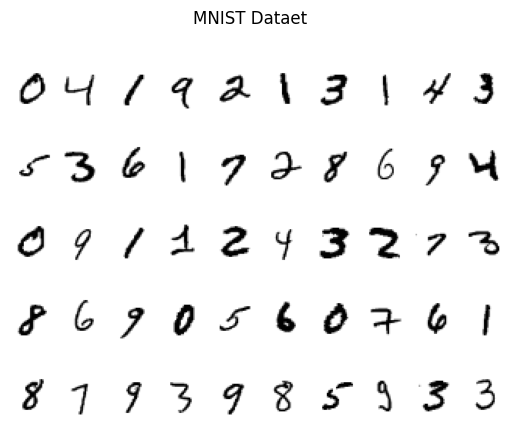

In [24]:
cols = 10
rows = 5
fig = plt.figure()
for index in range(1, rows*cols + 1):
    plt.subplot(rows, cols, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
plt.suptitle('MNIST Dataet')

# LeNet5

In [42]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.features_extractor = nn.Sequential(
            # layer 1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # (b x 6, x 28 x 28)
            nn.Tanh(),
            # layer 2
            nn.AvgPool2d(kernel_size=2, stride=2),# (b x 6 x 14 x 14) 
            nn.Tanh(),
            # layer 3
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # (b x 16, x 10 x 10)
            nn.Tanh(),
            # layer 4
            nn.AvgPool2d(kernel_size=2, stride=2), # (b x 16, x 5 x 5)
            nn.Tanh(),
            # layer 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), # (b x 120 x 1 x 1)
            nn.Tanh(),
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        x = self.features_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)

        return x

# Create Model

In [43]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(n_classes=N_CLASSES).to(device)

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Train

Epochs: 0, Train_loss: 0.07192509124279023, Valid_loss: 0.0002309701919555664, Train_accuracy: 9.871666666666666, Valid_accuracy: 9.81
Epochs: 1, Train_loss: 0.07182729414701462, Valid_loss: 0.00023063020706176759, Train_accuracy: 9.873333333333335, Valid_accuracy: 9.81
Epochs: 2, Train_loss: 0.07172921938896179, Valid_loss: 0.00023028857707977295, Train_accuracy: 9.89, Valid_accuracy: 9.82
Epochs: 3, Train_loss: 0.07162961958646774, Valid_loss: 0.0002299407482147217, Train_accuracy: 9.951666666666666, Valid_accuracy: 9.879999999999999
Epochs: 4, Train_loss: 0.07152723247210185, Valid_loss: 0.00022958247661590577, Train_accuracy: 10.133333333333333, Valid_accuracy: 10.02
Epochs: 5, Train_loss: 0.07142072914441426, Valid_loss: 0.00022920873165130614, Train_accuracy: 10.465, Valid_accuracy: 10.27
Epochs: 6, Train_loss: 0.0713086791197459, Valid_loss: 0.0002288149356842041, Train_accuracy: 11.213333333333333, Valid_accuracy: 11.06
Epochs: 7, Train_loss: 0.07118948073387146, Valid_loss: 0.

<ipython-input-14-c5110f9b645a>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


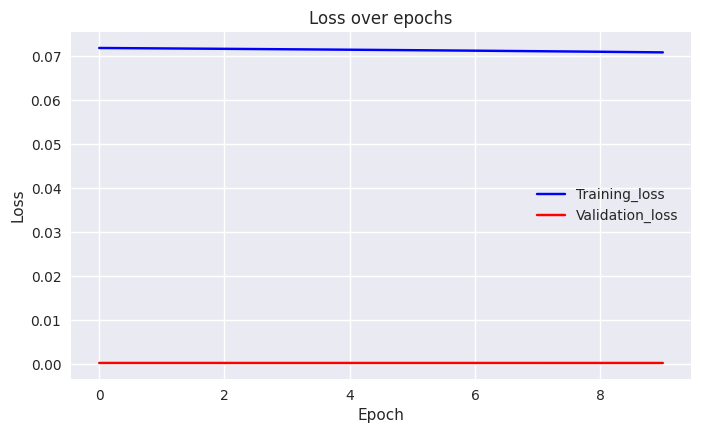

In [45]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device)

# Save model

In [ ]:
torch.save(model.state_dict(), 'LeNet5_model.ckpt')